In [1]:
!pip install geopy

     |████████████████████████████████| 112kB 7.0MB/s eta 0:00:01


In [33]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'id',
                  'Venue Category']
    
    return(nearby_venues)

In [4]:
CLIENT_ID = 'KSLYKBBETBM3S5Z0BHXC1LYSBRZJEYYNUAMEXMDEQDPU0MYW' # your Foursquare ID
CLIENT_SECRET = 'LIJL30PMHAV55RFRXHWNG222PC13I3IILGWOIQTE1Z5LVXHD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [5]:
data = [
    ['Notre-Dame de Paris', 48.852968,2.349902],
    ['Basilique du Sacré-Cœur', 48.8853464586,2.3391319768],
    ['Musée du Louvre', 48.864824,2.334595],
    ['Tour Eiffel', 48.858370,2.294481],
    ["Musée d'Orsay", 48.859961,2.326561],
    ['Centre Pompidou', 48.860642,2.352245],
    ['Arc de Triomphe',48.873792,2.295028],    
    ['Opéra Garnier', 48.869829854,2.325665364]
] 


DF = pd.DataFrame(data, columns = ['Nom','Latitude','Longitude'])

In [35]:
address = 'Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, location in zip(DF['Latitude'], DF['Longitude'], DF['Nom']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [70]:
Venues = getNearbyVenues(names=DF['Nom'],
                                   latitudes=DF['Latitude'],
                                   longitudes=DF['Longitude']
                                  )

Notre-Dame de Paris
Basilique du Sacré-Cœur
Musée du Louvre
Tour Eiffel
Musée d'Orsay
Centre Pompidou
Arc de Triomphe
Opéra Garnier


In [73]:
Venues.to_csv ('place.csv', index = False)

NameError: name 'Venues' is not defined

In [7]:
Venues = pd.read_csv('place.csv')  

In [8]:
Venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,id,Venue Category
0,Notre-Dame de Paris,48.852968,2.349902,Cathédrale Notre-Dame de Paris,48.853124,2.349561,4adcda09f964a520e83321e3,Church
1,Notre-Dame de Paris,48.852968,2.349902,Shakespeare & Company,48.852568,2.347096,4adcda21f964a520f23921e3,Bookstore
2,Notre-Dame de Paris,48.852968,2.349902,Sola,48.851569,2.348391,4d07738e347da1cd0c093b8f,Japanese Restaurant
3,Notre-Dame de Paris,48.852968,2.349902,Parvis Notre-Dame — Place Jean-Paul II,48.853407,2.348456,4c00046cc30a2d7fbeda111d,Plaza
4,Notre-Dame de Paris,48.852968,2.349902,Tours de la Cathédrale Notre-Dame de Paris,48.853230,2.349207,4e96e6a7f79068de88dd5eaf,Scenic Lookout


In [37]:
Venues.shape

(623, 8)

In [9]:
Venues.Neighborhood.unique()

array(['Notre-Dame de Paris', 'Basilique du Sacré-Cœur',
       'Musée du Louvre', 'Tour Eiffel', "Musée d'Orsay",
       'Centre Pompidou', 'Arc de Triomphe', 'Opéra Garnier'],
      dtype=object)

In [10]:
v = Venues.set_index(Venues.Neighborhood)
v = v[v.columns[-1]]
v = v.groupby(v.index).apply(lambda x: x.value_counts()/len(x))

In [24]:
frequency = pd.DataFrame(v.xs("Opéra Garnier"))

In [25]:
for i in Venues.Neighborhood.unique():
    
    frequency[i] = v.xs(i)

In [26]:
frequency = frequency.drop(columns=["Venue Category"])

<AxesSubplot:>

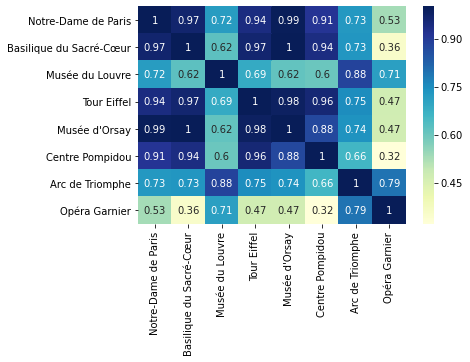

In [32]:
sns.heatmap(frequency.corr(), annot=True, cmap="YlGnBu")

In [38]:
v

Neighborhood                                            
Arc de Triomphe          French Restaurant                  0.180556
                         Hotel                              0.152778
                         Italian Restaurant                 0.069444
                         Sandwich Place                     0.027778
                         Electronics Store                  0.027778
                         Clothing Store                     0.027778
                         Steakhouse                         0.027778
                         Bistro                             0.027778
                         Japanese Restaurant                0.027778
                         Movie Theater                      0.027778
                         Bakery                             0.027778
                         Vegetarian / Vegan Restaurant      0.013889
                         Boutique                           0.013889
                         Creperie             